# GCN Code

### Latex Macros
$\newcommand{\Re}[1]{{\mathbb{R}^{{#1}}}}
\newcommand{\Rez}{{\mathbb{R}}}$

# Refactor and simplify first_GNN.ipynb into First_GNN_simplified.ipynb
Now that First_GNN_simplified produces the correct results, it is time to simplify the code, removing all extraneous and unnecessary sections. 

In the process, I will remove the support code from Luke, and just use tools from networkx. Luke will explain his code next week. 

In [1]:
%load_ext autoreload
%autoreload 2
#%tableofcontents

In [2]:
import torch
import tqdm.auto
from tqdm import tqdm
import os
from collections import defaultdict
import spectral_function_library as speclib
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
### We use the famous 'Karate Club' network as a test case. Our task is to
### predict the community to which each node belongs; formally, this would be
### called transductive binary node classification.

import networkx as nx
G = nx.karate_club_graph()

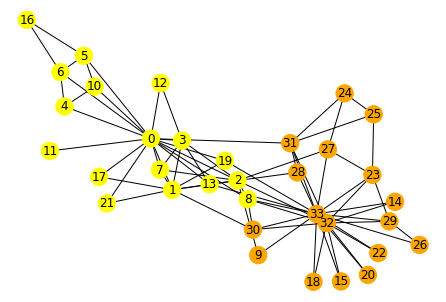

In [4]:
### Plot the network. We see it consists of a total of 34 nodes (numbered below 
### 0-33). Colors indicate class membership.
labels = [0 if G.nodes[idx]['club'] == 'Mr. Hi' else 1 for idx in range(len(G.nodes))]
colors = ['yellow'if labels[idx] == 0 else 'orange' for idx in range(len(G.nodes))]
pos = nx.drawing.layout.spring_layout(G)
nx.drawing.draw(G,pos=pos,with_labels=True,node_color=colors) 

# Features

In [35]:
# Different randomization for each run
nb_features = 16
nodes = np.asarray(G.nodes)
nb_nodes = nodes.shape[0]
node_metadata = np.random.randn(nb_nodes, nb_features)
labels = np.asarray([0 if G.nodes[node]['club'] == 'Mr. Hi' else 1 for node in list(G.nodes)])
mean = np.where(labels == 0, .5, 0)
node_metadata = mean.reshape(-1, 1) + node_metadata

# Add labels and metadata to the networkx graph `G`
G.node_metadata = node_metadata
G.labels = labels
G.nb_nodes = nb_nodes

# Plot the metadata

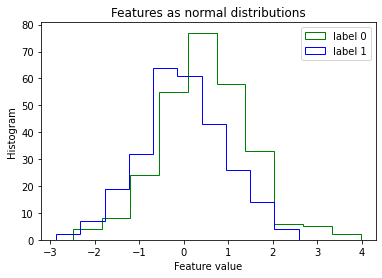

In [36]:
indices = np.asarray(range(nb_nodes))
indices_0 = indices[labels == 0]
indices_1 = indices[labels == 1]
features_0 = node_metadata[indices_0, :].reshape(-1)
features_1 = node_metadata[indices_1, :].reshape(-1)
plt.hist(features_0, color='green', histtype='step', label='label 0')
plt.hist(features_1, color='blue', histtype='step', label='label 1');
plt.title("Features as normal distributions")
plt.xlabel("Feature value")
plt.ylabel("Histogram")
plt.legend()

# Linear model is 
$$ H^{n+1} = A H^n W $$
where $H\in \Re{N\times d}$, $A\in\Re{N\times N}$, and $W\in\Re{d\times d}$ and $d$ is the number of features. In our synthetic example, we have 16 features, one label. `

In [37]:
softmax = torch.nn.functional.softmax
relu = torch.nn.functional.relu
sigmoid = torch.nn.functional.sigmoid
tanh = torch.nn.functional.tanh
activation = sigmoid

In [192]:
### Create a hand-crafted GNN without using a formal model.


def model_setup(G, frac_train=0.5, H0=None, nb_features=None, feature_type=None):
    """
    G is a networkx graph enhanced with fields `node_metadata` and `labels`

    Parameters
    ----------
    G : networkx graph

    frac_train: float
        The fraction of labels used for training

    H0: numpy array
        Initial feature matrix of dimension |V| x d, where d is the number of features

    nb_features: integer
        The number of features

    feature_type: str
        If `None`, use the 16-feature matrix of normal random numbers
        If 'degree', use the node degree

    Return values : a list of matrices
    -------------
    An : the normalized adjacency matrix (symmetrical normalization)

    H  : the feature matrix

    Y  : the labels

    W : a list of weights

    mask : torch tensor
        Zero's (labelled data used for training)
        One's (data used for testing)
    """
    # print("H0 shape in setup: ", H0.shape)
    # # Ensure result reproducibility
    # torch.manual_seed(100)
    nb_nodes = len(G.nodes)
    nb_edges = len(G.edges)
    A = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
    # Check that graph is undirected if ||A-A.T|| = 0

    # ATTENTION: THE NODE INDICES ARE NOT PERMUTED. IMPORTANT or NOT?

    # Kipf and Welling (2016)
    An = np.eye(nb_nodes) + A
    D = np.sum(An, axis=0)  # degree
    Dinvsq = np.diag(np.sqrt(1.0 / D))  # array
    An = Dinvsq @ An @ Dinvsq

    if H0 == None:
        H0 = G.node_metadata

    # Use -1 in case the matrix eventually changes number of dimensions
    if nb_features == None:
        nb_features = H0.shape[-1]
    else:
        # first column is a label
        H0 = G.node_metadata[:, 0:nb_features]

    if feature_type == "degree":
        nb_features = 1
        H0[:, 0] = np.sum(A, axis=0)
        H0[:, 0] /= np.max(H0[:, 0])  # normalize to the max degree

    if isinstance(H0, list):
        H0 = torch.tensor(H0).float()
    elif isinstance(H0, torch.Tensor):
        H0 = H0.clone().detach()
    else:
        print("type(H0) not handled: ", type(H0))

    H = H0[:, :nb_features]  # H only has features
    Y = torch.from_numpy(G.labels)

    # 0: training set (50%); 1: testing set (50%)
    # mask = torch.from_numpy(np.random.randint(0, 2, H0.shape[0]))
    mask = torch.from_numpy(
        np.random.choice(2, H0.shape[0], p=[frac_train, 1.0 - frac_train])
    )

    H0 = H  # features
    # Use -1 in case the matrix eventually changes number of dimensions
    if nb_features == None:
        nb_features = H0.shape[-1]

    # Initialize W with random numbers and allow gradient
    # computation of cost function with respect to (wrt) W

    W = []
    # I did initialize the weights, but only with non-scaled random numbers
    W.append(torch.rand(nb_features, nb_features, requires_grad=True))
    W.append(torch.rand(nb_features, 1, requires_grad=True))  # sigmoid output layer

    # Glorot Initialization
    rmax = 1 / nb_features ** 0.5
    for w in W:
        torch.nn.init.uniform_(w, -rmax, rmax)

    An = torch.from_numpy(An).float()

    # The input can be either torch.Tensor or numpy.ndarray
    if isinstance(H, np.ndarray):
        H = torch.from_numpy(H).float()
    if isinstance(H0, np.ndarray):
        H0 = torch.from_numpy(H0).float()
    if isinstance(Y, np.ndarray):
        Y = torch.from_numpy(Y).float()
    if isinstance(An, np.ndarray):
        An = torch.from_numpy(An).float()

    print("return from set_model, types: ")
    print(type(An), type(H), type(H0), type(Y), type(W), type(mask))
    return An, H, H0, Y, W, mask

In [193]:
def model(A, H0, W):
    """
    Semi-supervised GCN, similar to that of Kipf & Welling (2016)
    W : list of weights of different shapes
    """
    X = relu(A @ H0 @ W[0])
    X = sigmoid(A @ X @ W[1])
    return X

In [194]:
def cost(H, Y, mask, activation):
    """
    summation over all edges
    Training set: defined by mask[i] = 0
    H[i,0] is the probability of Y[i] == 1 (target probability)
    H[i,1] is the probability of Y[i] == 0 (target probability)
    """
    costf = 0
    
    if activation == "relu":
        for i in range(Y.shape[0]):
            if mask[i] == 0:  # training set
                costf -= (Y[i] * torch.log(H[i,0]) + (1-Y[i]) * torch.log(H[i,1]))
        
    elif activation == "sigmoid": 
        for i in range(Y.shape[0]):
            if mask[i] == 0:  # training set
                # costf -= torch.log(H[i,0])
                costf -= (Y[i] * torch.log(H[i,0]) + (1-Y[i]) * torch.log(1.-H[i,0]))
                
    else:
        print(f"activation {activation} is not supported.")
    
    return costf

In [195]:
def train(A, H, H0, Y, W, mask, nb_epochs, activation, lr=1.0e-2):

    # Follow https://www.analyticsvidhya.com/blog/2021/08/linear-regression-and-gradient-descent-in-pytorch/

    accuracy_count = defaultdict(list)
    loss = [cost(H0, Y, mask, activation)]

    for epoch in tqdm(range(nb_epochs)):
        H = model(A, H0, W)
        costf = cost(H, Y, mask, activation)
        loss.append(costf.item())

        if np.isnan(costf.detach().item()):
            print("costf is NaN")
            break
        with torch.no_grad():
            costf.backward(retain_graph=False)
            for w in W:
                w -= lr * w.grad
                w.grad.zero_()

        if epoch % 100 == 0:
            predict(
                A, H0, Y, W, mask, activation="sigmoid", accuracy_count=accuracy_count
            )
            pass

    return loss, accuracy_count

In [196]:
def predict(A, H0, Y, W, mask, activation, accuracy_count):
    
    # Follow https://www.analyticsvidhya.com/blog/2021/08/linear-regression-and-gradient-descent-in-pytorch/
    H = model(A, H0, W)
    
    if activation == "relu":
        count = [0,0]
        count_correct = [0,0]
        for i in range(H.shape[0]):
            if mask[i] == 1:
                count[0] += 1
                if H[i,0] > 0.5 and Y[i] > 0.9:
                    count_correct[0] += 1
                elif H[i,1] < 0.5 and Y[i] < 0.1:
                    count_correct[1] += 1
        perc0_corr = count_correct[0] / count[0]
        perc1_corr = count_correct[1] / count[0]
        print("sum(H): ", torch.sum(H, axis=0))
        print("Perc (%) class 0/1 correct: ", perc0_corr, perc1_corr)
    elif activation == "sigmoid":    # <<<< CASE BEING USED (2022-02-03)
        count_correct = [0,0]
        count = [0,0]
        for i in range(H.shape[0]):
            if mask[i] == 1: # test data
                count[1] += 1
                if H[i] > 0.5 and Y[i] > 0.9:
                    count_correct[1] += 1
                if H[i] < 0.5 and Y[i] < 0.1:
                    count_correct[1] += 1
            else:  # mask == 0, training data
                count[0] += 1
                if H[i] > 0.5 and Y[i] > 0.9:
                    count_correct[0] += 1
                if H[i] < 0.5 and Y[i] < 0.1:
                    count_correct[0] += 1

        accuracy_count['train'].append(count_correct[0] / count[0])
        accuracy_count['test'].append(count_correct[1] / count[1])
    else:
        print("predict(): Incorrect activation function")
        return

## Observations
By default, the features are two normal distributions (16 values per node, so there are 16 features). 
One Gaussian is placed over its appropriate label (there are two labels). With 16 features, I experiment with the fraction of nodes in the training set. I choose a fraction `frac_train` of the nodes as the training set. 

When `frac_train` goes to 0.05, there are very few nodes in the training set. However, as long is there is at least one node of each type, I get good test accuracy. 

For a given value of `frac_train`, testing accuracy goes down as I decrease the number of features. In the limit of a single feature, there is not enough information to distinguish the two distributions, and accuracy decreases.

To further test the code with 16 features, I permute the attributes amongst the nodes. Now, the two Gaussians no longer match the two labels in the graph. The label prediction  accuracy goes down substantially, ending up closer to 50% accuracy, which is random. 

One can also use structural information for features, such as node degree. I would not expect great accuracy in that case. 

In the cell that follows, feature_type is `None` specifies the two Gaussians centered at 0 and 1. If `feature_type` is `degree`, use the node degree as the single feature. The accuracy of the testing is quite low in that case. Sometimes I get zero accuracy on training and testing data, and sometimes I get about 50% on both. I do NOT know why I get zero accuracy when `frac_train=0.5`. Seems unlikely. When `frac_train=0.8`, I sometimes get zero, and sometimes 0.55 on training set and 0.2 on testing set. Obviously, the degree is a poor choice for a feature as it seems decorrelated from the labels. Note also, that I divided the degree by the maximum degree over the graph to keep it in the range `[0,1]`.

In [197]:
A, H, H0, Y, W, mask = model_setup(G, frac_train=0.8, nb_features=8, feature_type=None)
print("H: ", H.shape)
print("H0: ", H0.shape, type(H0))
print("nb_features: ", H.shape[1])
index = torch.where(mask == 0, True, False)
print("labels where mask == 0: ", Y[index])
loss, accuracy_count = train(A, H, H0, Y, W, mask, nb_epochs=1400, activation="sigmoid")

# When running frac_train=0.05 (0.05 * 34 = 1.7), I sometimes get 0, 1, or 2 0 masks. 
# When there are 0 training labels, I get an error
# When there is 1 training label, I get 50% error, i.e., 50% accuracy (random)
# When there are 2 training labels, I get close to 100% accuracy

type(H0) not handled:  <class 'numpy.ndarray'>
return from set_model, types: 
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'list'> <class 'torch.Tensor'>
H:  torch.Size([34, 8])
H0:  torch.Size([34, 8]) <class 'torch.Tensor'>
nb_features:  8
labels where mask == 0:  tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1])


  0%|          | 0/1400 [00:00<?, ?it/s]/Users/erlebach/opt/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 1400/1400 [00:03<00:00, 379.99it/s]


gordon


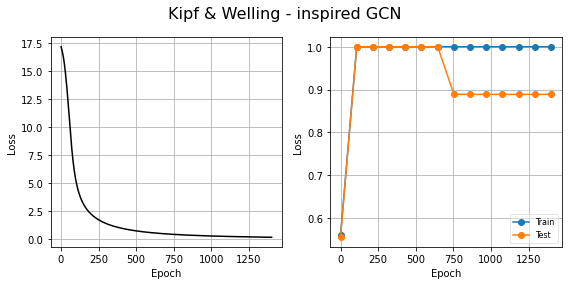

In [198]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
plt.suptitle("Kipf & Welling - inspired GCN", fontsize=16)
speclib.plot_one_curve(axes[0], loss, xlabel='Epoch', ylabel='Loss', style='-', title='')

y = np.asarray([v for k,v in accuracy_count.items()]).T  # shape: [N, 2]  
x = np.linspace(0, y.shape[0]*100, y.shape[0])
speclib.plot_multi_curves(axes[1], x, y, xlabel='Epoch', ylabel='Loss', title='', labels=['Train', 'Test'])

plt.tight_layout()
plt.show()

# Decoupling attributes/labels from structure
The question is: how important is the structural information? To determine that, we keep the graph fixed, but shuffle the labels across the graph nodes:
The number of each label will remain the same, but the labels, together with the attributes, will migrate to different nodes. 
Therefore, the edge connections  are no longer related to the edges. In that situation, one expects labelling accuracy to go down. 

This is accomplished by reshuffling the rows of `graph.node_metadata`. So first create a node permutation. 

In [199]:
A, H, H0, Y, W, mask = model_setup(G, frac_train=0.05) 

type(H0) not handled:  <class 'numpy.ndarray'>
return from set_model, types: 
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'list'> <class 'torch.Tensor'>


In [200]:
perm_nodes = torch.randperm(G.nb_nodes)
print("perm_nodes: ", perm_nodes)
print("H0.shape: ", H0.shape)
print(type(H0))
H0 = H0[perm_nodes]
print("H0.shape: ", H0.shape)

perm_nodes:  tensor([ 6, 25, 13, 21, 11, 10, 16, 19, 26, 17,  5, 31, 20,  3, 33, 30,  1, 18,
        28, 12,  9, 15,  2, 24,  8, 27,  4, 22, 29,  7, 23, 32, 14,  0])
H0.shape:  torch.Size([34, 16])
<class 'torch.Tensor'>
H0.shape:  torch.Size([34, 16])


In [212]:
A, H, H0, Y, W, mask = model_setup(G, frac_train=.2, H0=H0) 
index = torch.where(mask == 0, True, False)
loss, accuracy_count = train(A, H, H0, Y, W, mask, nb_epochs=5501, activation="sigmoid", lr=1.e-4)

return from set_model, types: 
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'list'> <class 'torch.Tensor'>


100%|██████████| 5501/5501 [00:06<00:00, 894.49it/s]


gordon


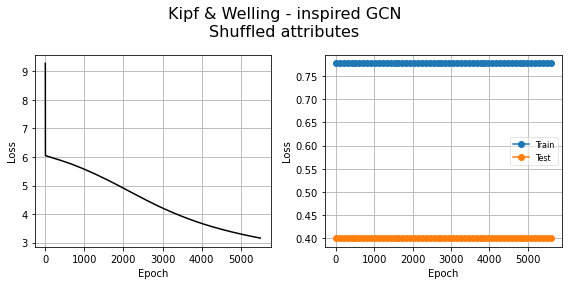

In [216]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
plt.suptitle("Kipf & Welling - inspired GCN\nShuffled attributes", fontsize=16)
speclib.plot_one_curve(axes[0], loss, xlabel='Epoch', ylabel='Loss', style='-', title='')

y = np.asarray([v for k,v in accuracy_count.items()]).T  # shape: [N, 2]  
x = np.linspace(0, y.shape[0]*100, y.shape[0])
speclib.plot_multi_curves(axes[1], x, y, xlabel='Epoch', ylabel='Loss', title='', labels=['Train', 'Test'])

plt.tight_layout()
plt.show()

## Observations
* When I shuffled the features to decorrelate them with respect to the labels, the loss function decreases rather differently than before. WHY? 